In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split


In [ ]:
class OurNNForMNIST:

    def __init__(self, x_train, y_train, x_test, y_test, batch_size=32, lr=1e-2, check_v=0.00001, max_epoch=20,input_dim=784,h1=20,h2=15,output_dim=10):

        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        self.batch_size = batch_size
        self.lr = lr
        self.check_v = check_v
        self.max_epoch = max_epoch
        self.input_dim=input_dim
        self.h1=h1
        self.h2=h2
        self.output_dim=output_dim
        self.train_loss_l = []
        self.test_loss_l = []

    def our_tanh(self, x):

        upper = np.exp(x) - np.exp(-x)

        lower = np.exp(x) + np.exp(-x)

        return upper / lower

    def our_dtanh(self, x):

        return 1 - x**2

    def our_soft_max(self, x):

        x = x - np.max(x, axis=1, keepdims=True)

        upper = np.exp(x)

        lower = np.sum(upper, axis=1, keepdims=True)

        return upper / lower

    def our_cross_entropy(self, t, p):

        return np.mean(-np.sum(t * np.log(p + 0.00000005), axis=1, keepdims=True))

    def our_initial(self):

        w1 = np.random.randn(self.input_dim, self.h1)
        b1 = np.zeros((1, self.h1))

        w2 = np.random.randn(self.h1, self.h2)
        b2 = np.zeros((1, self.h2))

        w3 = np.random.randn(self.h2, self.output_dim)
        b3 = np.zeros((1, self.output_dim))

        return w1, b1, w2, b2, w3, b3

    def our_forward(self, x, w1, b1, w2, b2, w3, b3):

        n1 = x @ w1 + b1
        o1 = self.our_tanh(n1)

        n2 = o1 @ w2 + b2
        o2 = self.our_tanh(n2)

        n3 = o2 @ w3 + b3
        o3 = self.our_soft_max(n3)

        return n1, o1, n2, o2, n3, o3

    def our_backprob(self, x, y, w1, b1, w2, b2, w3, b3, n1, o1, n2, o2, n3, o3):

        de_dn3 = o3 - y

        de_do2 = de_dn3 @ w3.T

        de_dn2 = de_do2 * self.our_dtanh(o2)

        de_do1 = de_dn2 @ w2.T

        de_dn1 = de_do1 * self.our_dtanh(o1)


        de_dw3 = o2.T @ de_dn3

        de_db3 = np.sum(de_dn3, axis=0, keepdims=True)

        de_dw2 = o1.T @ de_dn2

        de_db2 = np.sum(de_dn2, axis=0, keepdims=True)

        de_dw1 = x.T @ de_dn1

        de_db1 = np.sum(de_dn1, axis=0, keepdims=True)

        return de_dw1, de_db1, de_dw2, de_db2, de_dw3, de_db3

    def our_update_weights(self, w1, b1, w2, b2, w3, b3, de_dw1, de_db1, de_dw2, de_db2, de_dw3, de_db3):

        w1 -= self.lr * de_dw1

        b1 -= self.lr * de_db1

        w2 -= self.lr * de_dw2

        b2 -= self.lr * de_db2

        w3 -= self.lr * de_dw3

        b3 -= self.lr * de_db3

        return w1, b1, w2, b2, w3, b3

    def our_accuracy(self, t, p):

        predicted_y = np.argmax(p, axis=1)

        true_t = np.argmax(t, axis=1)

        true_v = np.sum(true_t == predicted_y)

        total_v = predicted_y.shape[0]

        accuracy_v = true_v / total_v

        return accuracy_v

    def our_evaluation(self, x_eval, y_eval, w1, b1, w2, b2, w3, b3):

        n1, o1, n2, o2, n3, o3 = self.our_forward(x_eval, w1, b1, w2, b2, w3, b3)

        loss_v = self.our_cross_entropy(y_eval, o3)

        accuracy_v = self.our_accuracy(y_eval, o3)

        return loss_v, accuracy_v

    def our_batch_gradient_decent(self):

        np.random.seed(0)

        w1, b1, w2, b2, w3, b3 = self.our_initial()

        n_batches = len(self.x_train) // self.batch_size


        for epoch in range(self.max_epoch):

            for batch in range(n_batches):

                start = batch * self.batch_size

                end = (batch + 1) * self.batch_size

                if batch + 1 != n_batches:
                    x_batch = self.x_train[start:end]
                    y_batch = self.y_train[start:end]
                else:
                    x_batch = self.x_train[start:]
                    y_batch = self.y_train[start:]

                n1, o1, n2, o2, n3, o3 = self.our_forward(x_batch, w1, b1, w2, b2, w3, b3)

                de_dw1, de_db1, de_dw2, de_db2, de_dw3, de_db3 = self.our_backprob(x_batch, y_batch, w1, b1, w2, b2, w3, b3, n1, o1, n2, o2, n3, o3)

                w1, b1, w2, b2, w3, b3 = self.our_update_weights(w1, b1, w2, b2, w3, b3, de_dw1, de_db1, de_dw2, de_db2, de_dw3, de_db3)

            train_loss, train_accuracy = self.our_evaluation(self.x_train, self.y_train, w1, b1, w2, b2, w3, b3)

            self.train_loss_l.append(train_loss)

            test_loss, test_accuracy = self.our_evaluation(self.x_test, self.y_test, w1, b1, w2, b2, w3, b3)

            self.test_loss_l.append(test_loss)

            print(f"at epoch = {epoch}, train loss = {train_loss}, test loss = {test_loss}, train accuracy = {train_accuracy}, test accuracy = {test_accuracy}")

        return w1, b1, w2, b2, w3, b3, self.train_loss_l, self.test_loss_l

In [ ]:
def our_prep_data(x_dir,y_dir):

    x=np.load(x_dir)
    y=np.load(y_dir)

    x=x / 255.0

    ohe=OneHotEncoder(sparse=False)

    y_ohe=ohe.fit_transform(y.reshape(-1,1))

    x_train,x_test,y_train,y_test=train_test_split(x,y_ohe,test_size=0.2,random_state=42)

    return x_train,x_test,y_train,y_test

In [ ]:
x_train,x_test,y_train,y_test = our_prep_data(x_dir="D:\Courses\ML Dr Mostafa\Projects_last\mnist-sample\X.npy",y_dir="D:\Courses\ML Dr Mostafa\Projects_last\mnist-sample\y.npy")


In [ ]:
our_nn=OurNNForMNIST(x_train,y_train,x_test,y_test,batch_size=32,lr=1e-2,check_v=0.00001,max_epoch=20)


In [ ]:
w1,b1,w2,b2,w3,b3,train_loss_l,test_loss_l=our_nn.our_batch_gradient_decent()

at epoch = 0, train loss = 1.1729549304540772, test loss = 1.2462710733103208, train accuracy = 0.60775, test accuracy = 0.59
at epoch = 1, train loss = 0.9418656380957551, test loss = 1.0338613355877178, train accuracy = 0.6795, test accuracy = 0.657
at epoch = 2, train loss = 0.806989864372359, test loss = 0.9246826336333278, train accuracy = 0.723, test accuracy = 0.69
at epoch = 3, train loss = 0.7100278933238425, test loss = 0.8537747543619707, train accuracy = 0.757, test accuracy = 0.722
at epoch = 4, train loss = 0.6625282621525244, test loss = 0.8094155453933927, train accuracy = 0.77775, test accuracy = 0.735
at epoch = 5, train loss = 0.6397289909551244, test loss = 0.8031842482022467, train accuracy = 0.78275, test accuracy = 0.737
at epoch = 6, train loss = 0.6241909960442251, test loss = 0.8125768376602528, train accuracy = 0.7845, test accuracy = 0.738
at epoch = 7, train loss = 0.5289064436224689, test loss = 0.712568091433487, train accuracy = 0.81825, test accuracy = 

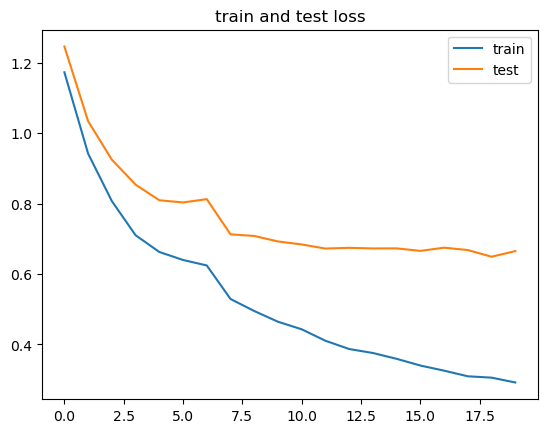

In [ ]:
def our_plot_loss(train_loss_l,test_loss_l):
    plt.plot(train_loss_l,label="train")
    plt.plot(test_loss_l,label="test")
    plt.legend()
    plt.title("train and test loss")
    plt.show()

our_plot_loss(train_loss_l,test_loss_l)

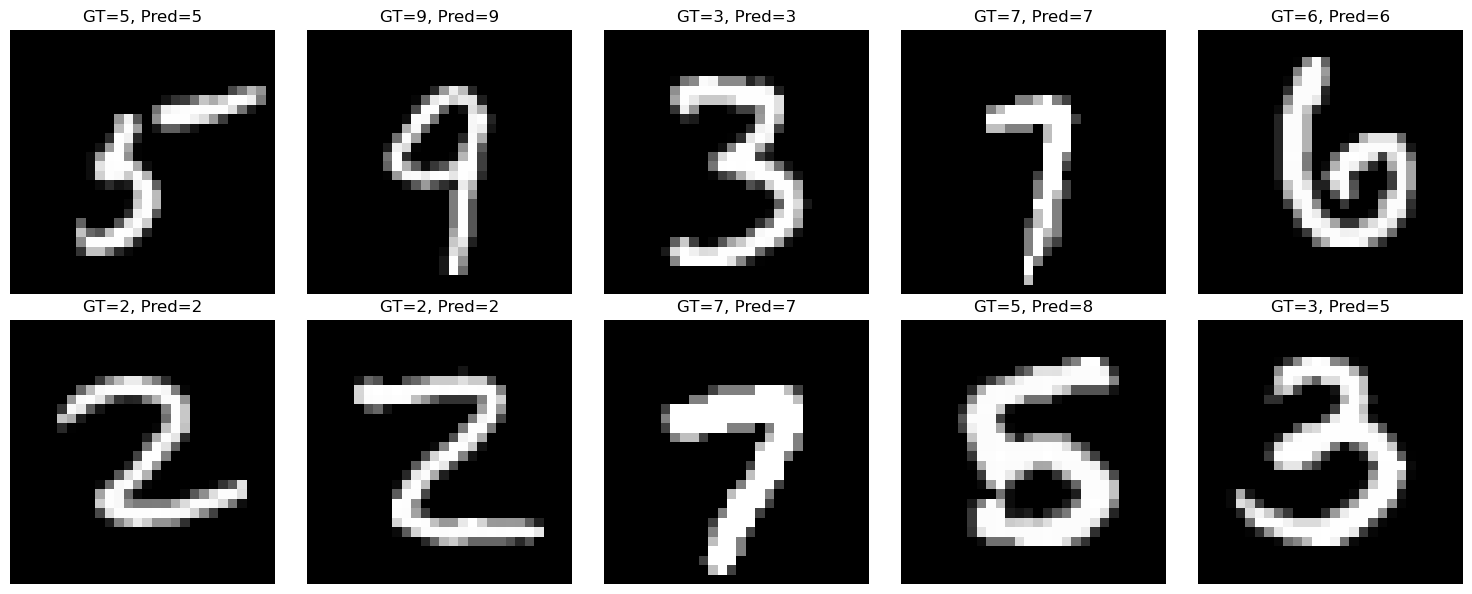

In [ ]:
def our_plot(x, y, w1, b1, w2, b2, w3, b3):
    num_images = 10
    rows = int(np.ceil(num_images / 5))
    cols = 5

    fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))
    axes = axes.flatten()

    for i in range(num_images):
        n1, o1, n2, o2, n3, o3 = our_nn.our_forward(x[i], w1, b1, w2, b2, w3, b3)
        t = np.argmax(y[i])
        p = np.argmax(o3)

        axes[i].imshow(x[i].reshape(28, 28), cmap='gray')
        axes[i].set_title(f"GT={t}, Pred={p}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

our_plot(x_test, y_test, w1, b1, w2, b2, w3, b3)